In [33]:
import pandas as pd
import os
import numpy as np

dir = 'hourly_averages/Indoor'

data = dict()
df = None
i = 1

files = [f for f in os.listdir(dir) if f.endswith('csv')]

for file in files:

    columns = ['time'] + [f"{col}_{file.split('.')[0]}" for col in ['current_temp_f', 'current_humidity', 'pm2_5_atm', 'p_0_3_um', 'p_0_5_um', 'p_1_0_um', 'p_2_5_um', 'p_5_0_um', 'p_10_0_um']]
    file = pd.read_csv(os.path.join(dir, file), parse_dates=["time"])
    file = file[['time', 'current_temp_f', 'current_humidity', 'pm2_5_atm', 'p_0_3_um', 'p_0_5_um', 'p_1_0_um', 'p_2_5_um', 'p_5_0_um', 'p_10_0_um']].copy()
    file.columns = columns
    if df is None:
        df = file
    else:
        df = pd.merge(df, file, on="time", how="outer")

    i+=1

In [34]:
# Converting the df to a numpy array
X = df.drop(["time"], axis = 1).to_numpy()

In [35]:
# Performing SoftImpute on the numpy array
from fancyimpute import SoftImpute

X_imputed = SoftImpute(verbose=False).fit_transform(X)
X_imputed[X_imputed < 0] = 0
# nmf = nimfa.Nmf(V_imputed, rank=2)
# fit = nmf()


d:\pyvenv\all_in_one\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\pyvenv\all_in_one\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\pyvenv\all_in_one\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### NMF

In [36]:
from torchnmf.nmf import NMF
import torch

nmf_in = NMF(X_imputed.shape, rank=4)
nmf_in.fit(torch.tensor(X_imputed), max_iter=2000)

120

In [37]:
H_in = nmf_in.W.T.cpu().detach().numpy()
W_in= nmf_in.H.cpu().detach().numpy()

[[   0.98    0.6     8.2  1287.53  346.22   95.96   19.14    4.35    3.57
    18.47    9.21    3.08  815.65  163.67    4.75    0.12    0.      0.
     0.3     0.01   17.76 2729.77  774.82  221.28   21.52    2.31    0.84
     1.1     0.37   35.22 4997.94 1469.24  392.75   39.98    4.51    2.17
     0.34    0.04   38.11 5724.65 1621.74  424.43   53.75   10.04    3.75
    13.41    9.39    0.     13.27    0.      0.      0.      0.      0.  ]
 [  19.47   11.85    8.15 1114.28  299.27   68.8    10.92    1.88    1.55
    38.04   24.06    7.38 1304.77  296.1    43.96    3.68    0.      0.
    26.98   16.31   39.35 5915.36 1640.45  447.8    43.07    6.79    2.32
    23.78   14.86   26.33 3554.51 1029.94  260.29   25.48    2.8     1.38
    25.9    14.41    7.52  958.93  259.81   55.46    7.18    1.1     0.46
    31.46   21.3     2.2   907.79  145.84    0.      0.      0.      0.  ]
 [  38.79   21.76   27.31 3945.11 1119.99  263.78   27.16    3.      2.37
    22.74   13.57   20.49 3210.49  882.9

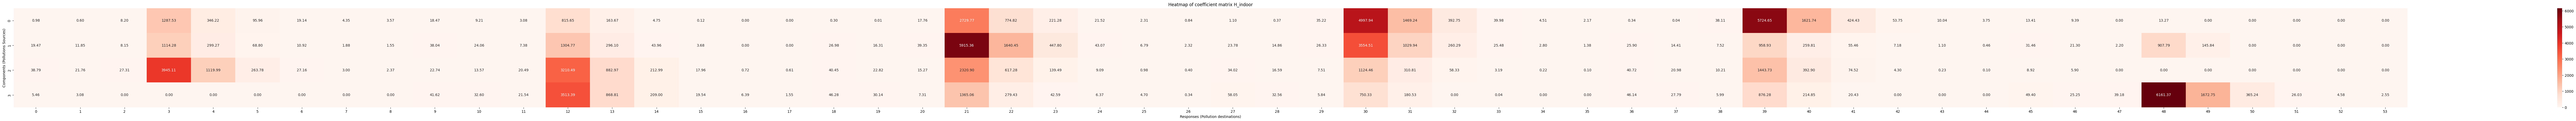

In [38]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Show H_7 with 2 decimals
np.set_printoptions(precision=2, suppress=True)
print(H_in.round(2))

# Draw heatmap
plt.figure(figsize=(150, 5))
sns.heatmap(H_in, annot=True, fmt=".2f", cmap="Reds")
plt.title("Heatmap of H_in")
plt.xlabel("Responses (Pollution destinations)")
plt.ylabel("Components (Pollutions Sources)")
plt.title("Heatmap of coefficient matrix H_indoor")
plt.show()

### Source Contribution

C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\785543605.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([col.replace("_" + "Mohammadpur", "") for col in necessary_species_names], rotation=90)


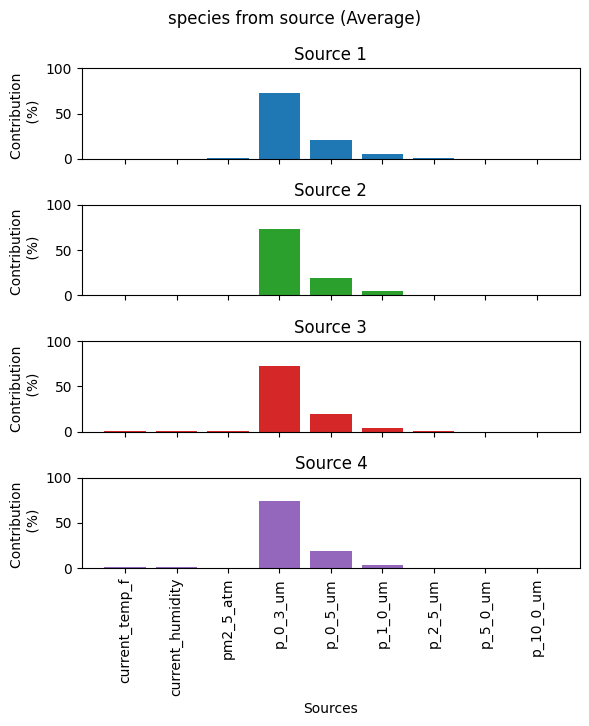

In [39]:
import numpy as np

## Contribution of each component to the responses
import matplotlib.pyplot as plt

n_components = H_in.shape[0]
n_responses = H_in.shape[1]

species_names = df.columns[1::]  # skip 'time' column

h_df = pd.DataFrame(H_in, columns=species_names)

necessary_species_names = [col for col in species_names if "Mohammadpur" in col]

colors = [
    "#1F77B4",  # Steel Blue
    "#2CA02C",  # Emerald Green
    "#D62728",  # Deep Red
    "#9467BD",  # Muted Purple
    "#8C564B",  # Earthy Brown
    "#E377C2",  # Rose Pink
    "#7F7F7F",  # Neutral Gray
    "#17BECF",  # Teal
    "#BCBD22"   # Olive Green
]

fig, axes = plt.subplots(n_components, figsize=(6, 7), sharey=True)
axes = axes.flatten()

for i in range(n_components):
    curr_data = h_df.iloc[i, :].values.reshape(6, -1)
    averages = curr_data.mean(axis = 0)
    axes[i].bar(
        species_names[:9],  # Use the first 9 species names
        averages/ averages.sum() * 100,
        color=colors[i]
    )
    axes[i].set_title(f"Source {i+1}")
    axes[i].set_ylabel('Contribution \n (%)')
    axes[i].set_ylim(0, 100)

    # Show x-axis label and ticks only on the last subplot
    if i == n_components - 1:
        axes[i].set_xlabel('Sources')
        axes[i].set_xticklabels([col.replace("_" + "Mohammadpur", "") for col in necessary_species_names], rotation=90)
    else:
        axes[i].set_xticklabels([])  # Hide tick labels
        axes[i].set_xlabel('')       # Hide label

plt.tight_layout()
plt.suptitle('species from source (Average)', y=1.03)
plt.show()

C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\619306512.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([col.replace("_" + location, "") for col in necessary_species_names], rotation=90)


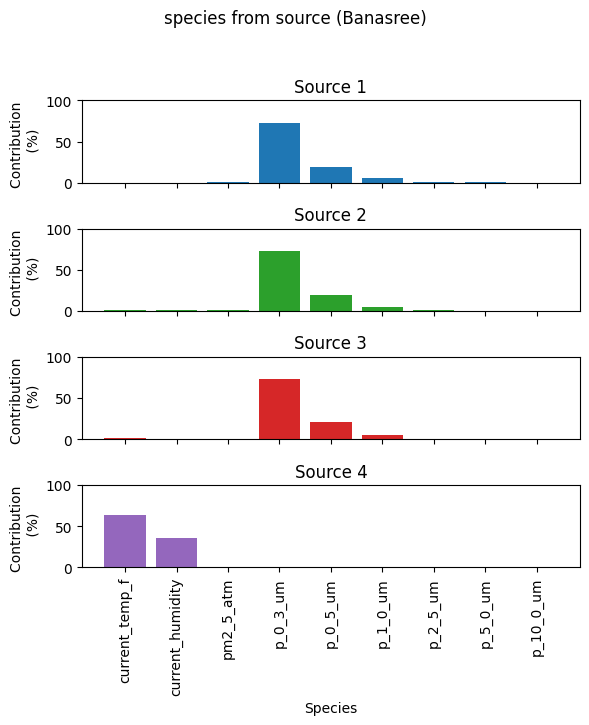

C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\619306512.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([col.replace("_" + location, "") for col in necessary_species_names], rotation=90)


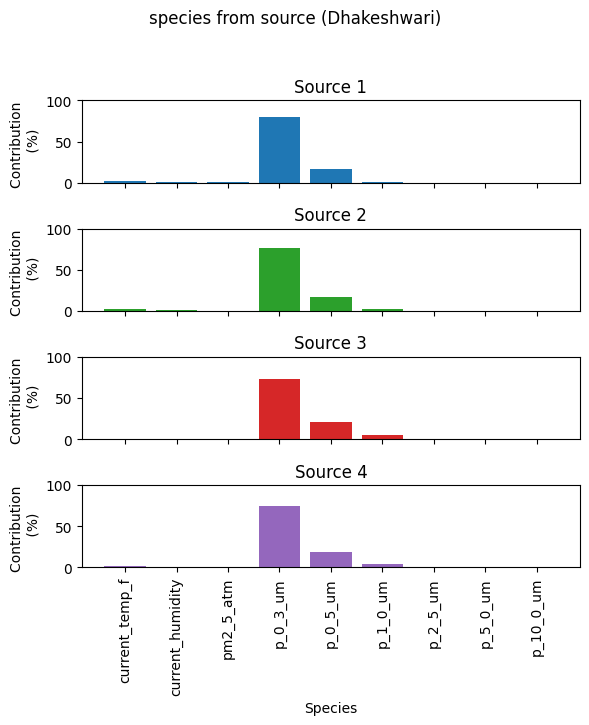

C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\619306512.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([col.replace("_" + location, "") for col in necessary_species_names], rotation=90)


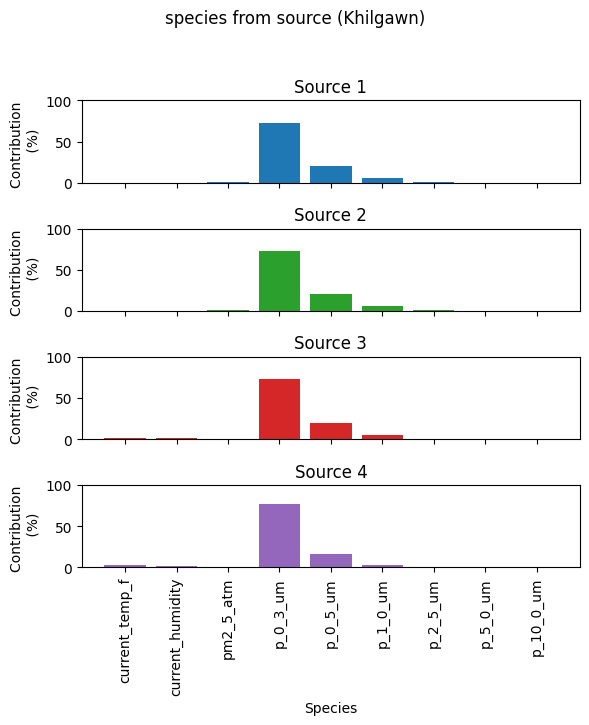

C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\619306512.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([col.replace("_" + location, "") for col in necessary_species_names], rotation=90)


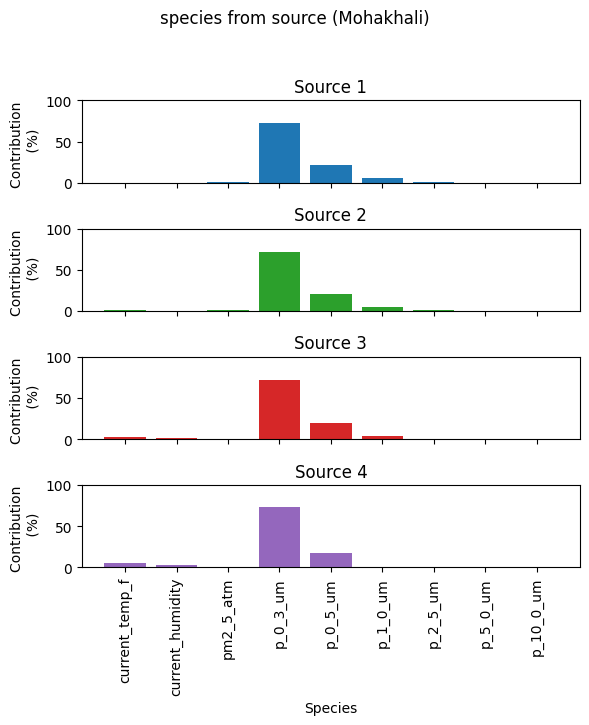

C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\619306512.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([col.replace("_" + location, "") for col in necessary_species_names], rotation=90)


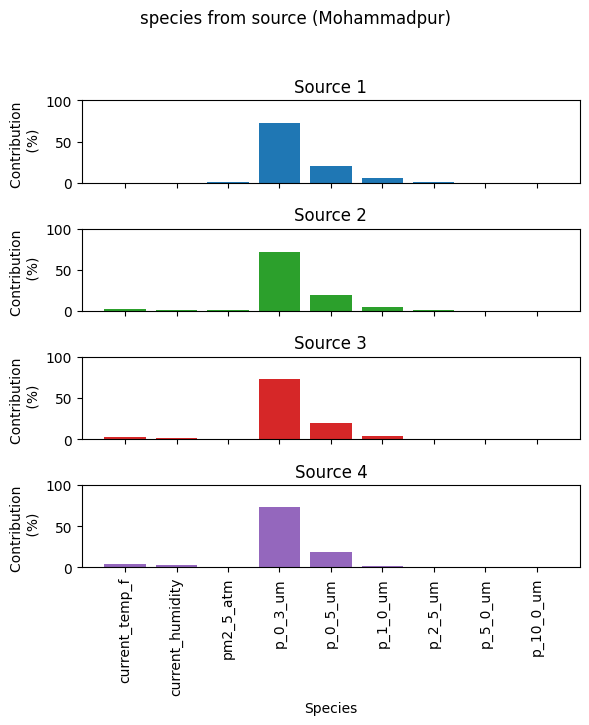

C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\619306512.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([col.replace("_" + location, "") for col in necessary_species_names], rotation=90)


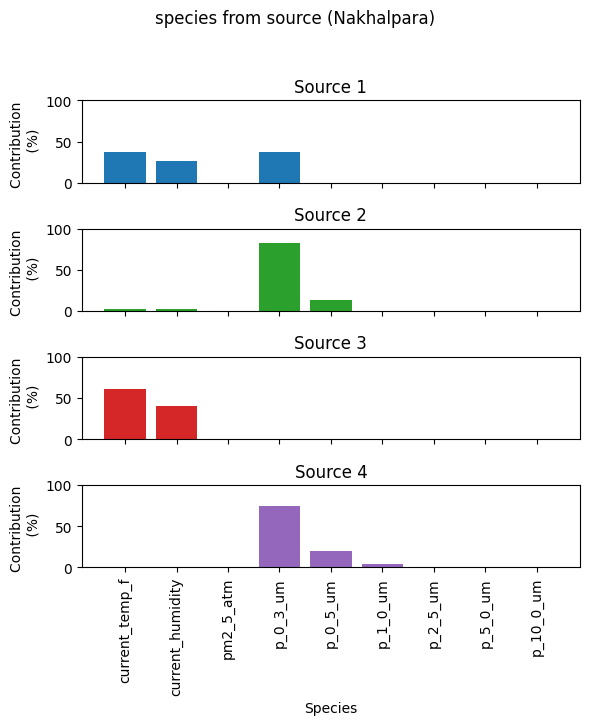

In [40]:
import numpy as np

## Contribution of each component to the responses
import matplotlib.pyplot as plt

n_components = H_in.shape[0]
n_responses = H_in.shape[1]

species_names = df.columns[1::]  # skip 'time' column

h_df = pd.DataFrame(H_in, columns=species_names)
locations = ['Banasree', 'Dhakeshwari', 'Khilgawn', 'Mohakhali', 'Mohammadpur', 'Nakhalpara']

for location in locations:
    necessary_species_names = [col for col in species_names if location in col]



    colors = [
        "#1F77B4",  # Steel Blue
        "#2CA02C",  # Emerald Green
        "#D62728",  # Deep Red
        "#9467BD",  # Muted Purple
        "#8C564B",  # Earthy Brown
        "#E377C2",  # Rose Pink
        "#7F7F7F",  # Neutral Gray
        "#17BECF",  # Teal
        "#BCBD22"   # Olive Green
    ]

    fig, axes = plt.subplots(n_components, figsize=(6, 7), sharey=True)
    axes = axes.flatten()

    for i in range(n_components):
        axes[i].bar(
            species_names[:9],
            h_df.loc[i, necessary_species_names].values / h_df.loc[i, necessary_species_names].values.sum() * 100,
            color=colors[i]
        )
        axes[i].set_title(f"Source {i+1}")
        axes[i].set_ylabel('Contribution \n (%)')
        axes[i].set_ylim(0, 100)

        # Show x-axis label and ticks only on the last subplot
        if i == n_components - 1:
            axes[i].set_xlabel('Species')
            axes[i].set_xticklabels([col.replace("_" + location, "") for col in necessary_species_names], rotation=90)
        else:
            axes[i].set_xticklabels([])  # Hide tick labels
            axes[i].set_xlabel('')       # Hide label

    
    plt.suptitle(f'species from source ({location})', y=1.03)
    plt.tight_layout()
    plt.savefig(f'images/species_from_source_{location}.png', bbox_inches='tight')
    plt.show()

### Component contribution

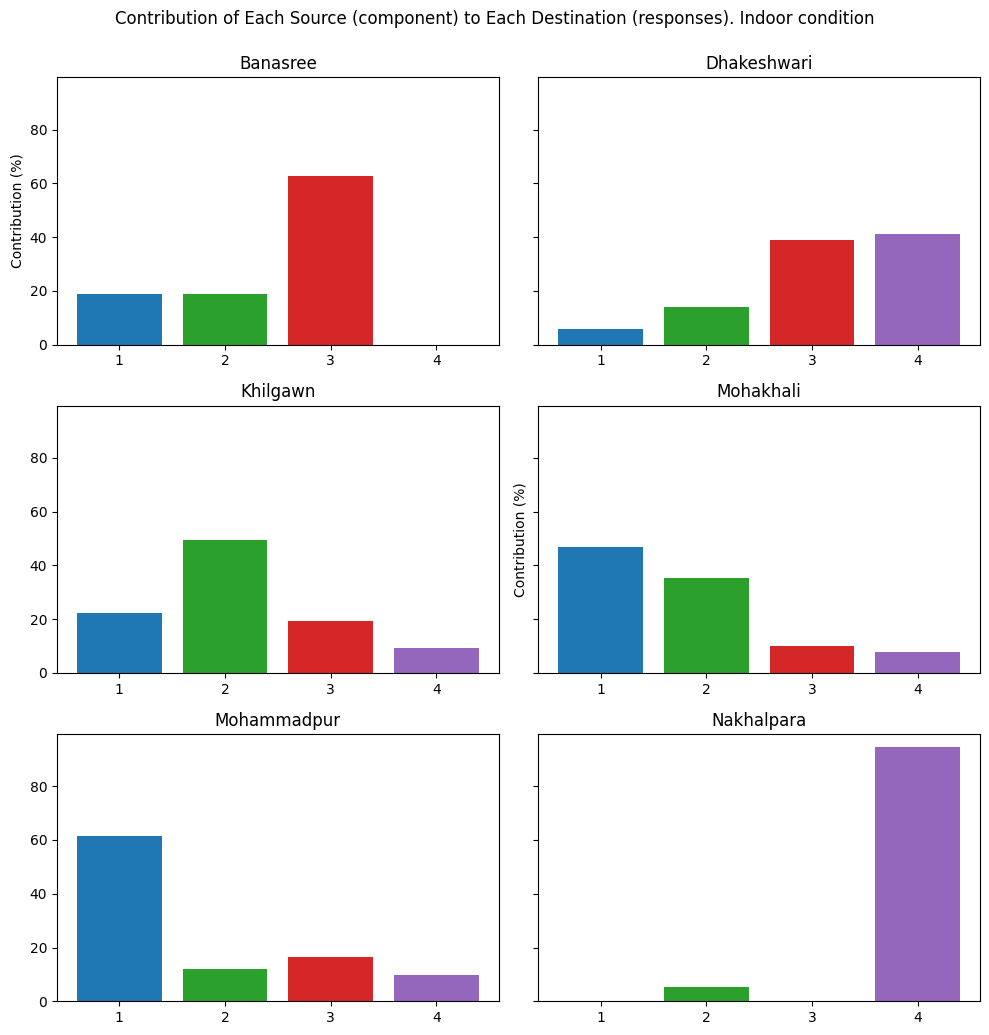

In [47]:
import numpy as np

## Contribution of each component to the responses
import matplotlib.pyplot as plt

n_components = H_in.shape[0]
n_responses = H_in.shape[1]//9

response_names = df.columns[1::9]  # skip 'time' column
response_names = response_names

colors = [
    "#1F77B4",  # Steel Blue
    "#2CA02C",  # Emerald Green
    "#D62728",  # Deep Red
    "#9467BD",  # Muted Purple
    "#8C564B",  # Earthy Brown
    "#E377C2",  # Rose Pink
    "#7F7F7F",  # Neutral Gray
    "#17BECF",  # Teal
    "#BCBD22"   # Olive Green
]

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
axes = axes.flatten()

for i in range(n_responses):
    axes[i].bar(range(1, n_components + 1), H_in[:, i*9+2] / H_in[:, i*9+2].sum() * 100, color = colors[:n_components])
    axes[i].set_xticks(range(1, n_components + 1))
    # axes[i].set_xlabel('Sources')
    axes[i].set_title(response_names[i].split('_')[-1])
    if i % 3 == 0:
        axes[i].set_ylabel('Contribution (%)')
    if i > 11:
        axes[i].set_xlabel('Sources')

plt.tight_layout()
plt.suptitle('Contribution of Each Source (component) to Each Destination (responses). Indoor condition', y=1.03)
plt.show()

### Source wise diurnal

In [42]:
import pandas as pd

# Create a DataFrame for W_7 with appropriate column names
W_in_df = pd.DataFrame(W_in, columns=[f"source{i+1}" for i in range(W_in.shape[1])])

# Add the 'time' column from df
W_in_df.insert(0, 'time', df['time'].iloc[:W_in.shape[0]].values)
W_in_df['month'] = W_in_df['time'].dt.month
W_in_df['hour'] = W_in_df['time'].dt.hour.apply(lambda x: 24 if x == 0 else x)
# Display the head of the new DataFrame
W_in_df.head()

,time,source1,source2,source3,source4,month,hour
0,2023-07-01 00:30:00,0.184212,0.105391,0.356077,1.875279e-07,7,24
1,2023-07-01 01:30:00,0.128147,0.078234,0.308929,1.706662e-02,7,1
2,2023-07-01 02:30:00,0.084575,0.061204,0.246466,2.352412e-02,7,2
3,2023-07-01 03:30:00,0.078880,0.060377,0.240519,3.061510e-02,7,3
4,2023-07-01 04:30:00,0.163079,0.064127,0.537617,1.756512e-01,7,4


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\2158503124.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['hour'] = df_season['hour'].apply(lambda x: 24 if x == 0 else x)


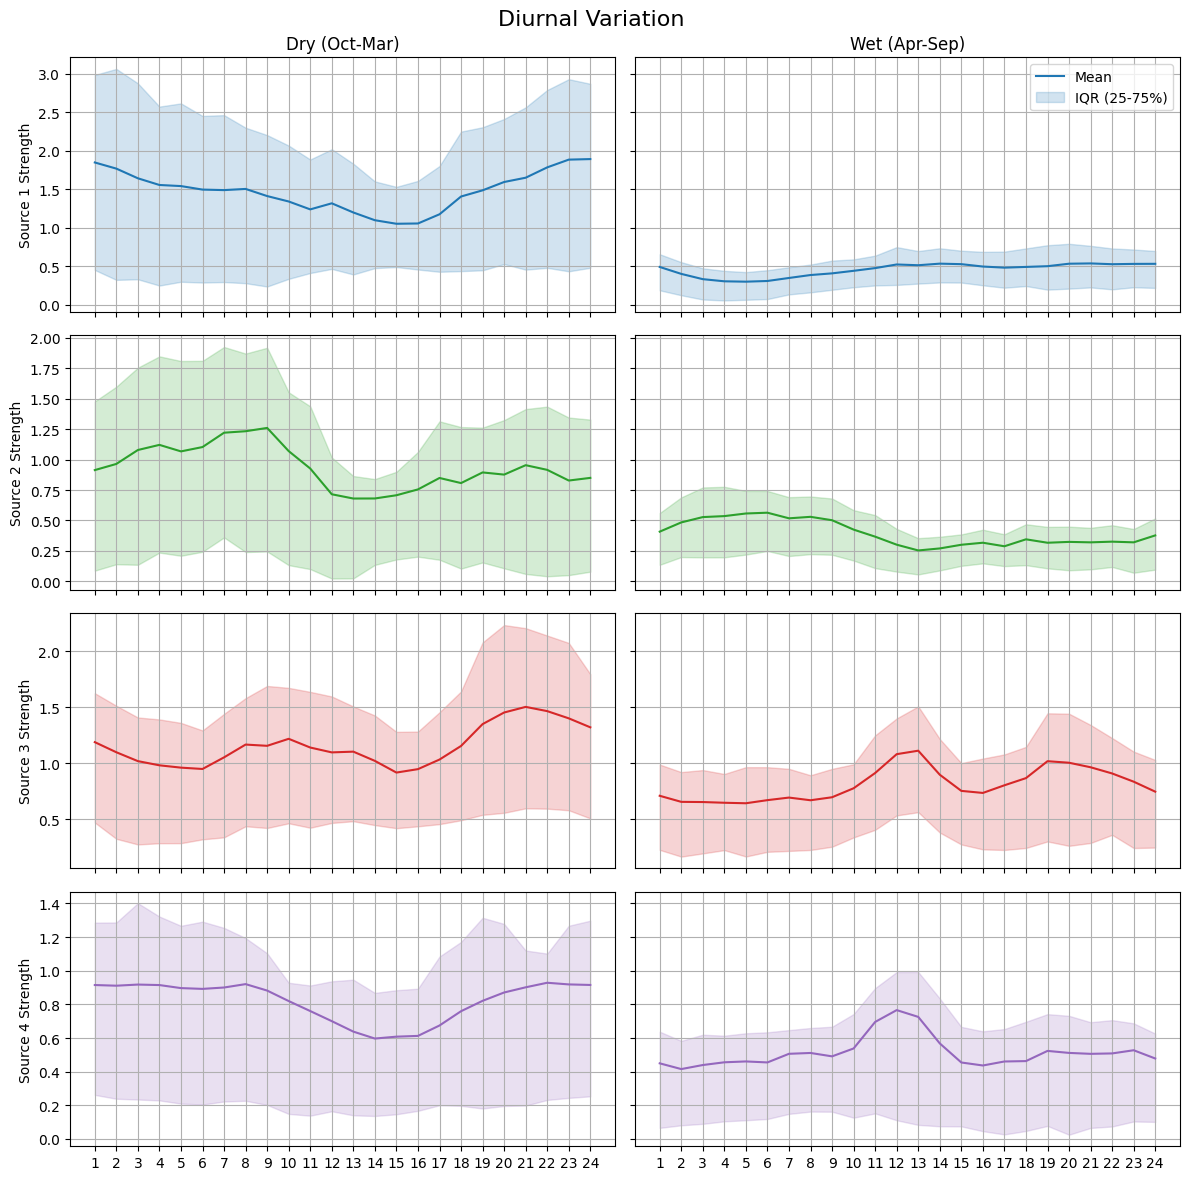

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# List of source columns
source_cols = [col for col in W_in_df.columns if col.startswith('source')]
n_sources = len(source_cols)
season_names = ['Dry (Oct-Mar)', 'Wet (Apr-Sep)']
dry_months = [10, 11, 12, 1, 2, 3]  # October to March
wet_months = [4, 5, 6, 7, 8, 9]

colors = [
    "#1F77B4",  # Steel Blue
    "#2CA02C",  # Emerald Green
    "#D62728",  # Deep Red
    "#9467BD",  # Muted Purple
    "#8C564B",  # Earthy Brown
    "#E377C2",  # Rose Pink
    "#7F7F7F",  # Neutral Gray
    "#17BECF",  # Teal
    "#BCBD22"   # Olive Green
]

season_months = [dry_months, wet_months]
# colors = plt.cm.tab10.colors

fig, axes = plt.subplots(n_sources, 2, figsize=(12, 3 * n_sources), sharex=True, sharey='row')

for row, source in enumerate(source_cols):
    for col, (months, season) in enumerate(zip(season_months, season_names)):
        ax = axes[row, col] if n_sources > 1 else axes[col]
        mask = W_in_df['month'].isin(months)
        df_season = W_in_df[mask]
        df_season['hour'] = df_season['hour'].apply(lambda x: 24 if x == 0 else x)
        grouped = df_season.groupby('hour')[source]
        mean = grouped.mean()
        q1 = grouped.quantile(0.25)
        q3 = grouped.quantile(0.75)
        hours = mean.index
        ax.plot(hours, mean, color=colors[row])
        ax.fill_between(hours, q1, q3, color=colors[row], alpha=0.2)
        if row == 0:
            ax.set_title(season)
        if col == 0:
            ax.set_ylabel(f'Source {row+1} Strength')
        ax.set_xticks(range(1, 25))
        ax.grid(True)
        if row == 0 and col == 1:
            ax.legend(['Mean', 'IQR (25-75%)'], loc='upper right')

plt.suptitle("Diurnal Variation ", fontsize=16)
plt.tight_layout()
plt.show()


### Source wise weekly

In [44]:
import pandas as pd

# Create a DataFrame for W_7 with appropriate column names
W_in_df = pd.DataFrame(W_in, columns=[f"source{i+1}" for i in range(W_in.shape[1])])

# Add the 'time' column from df
W_in_df.insert(0, 'time', df['time'].iloc[:W_in.shape[0]].values)
W_in_df['month'] = W_in_df['time'].dt.month
W_in_df['hour'] = W_in_df['time'].dt.hour.apply(lambda x: 24 if x == 0 else x)
W_in_df['day_of_week'] = W_in_df['time'].dt.day_name()  # Monday=0, Sunday=6

day_order = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert column to categorical
W_in_df['day_of_week'] = pd.Categorical(W_in_df['day_of_week'], 
                                        categories=day_order, 
                                        ordered=True)
# Display the head of the new DataFrame
W_in_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12830 entries, 0 to 12829
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         12830 non-null  datetime64[ns]
 1   source1      12830 non-null  float32       
 2   source2      12830 non-null  float32       
 3   source3      12830 non-null  float32       
 4   source4      12830 non-null  float32       
 5   month        12830 non-null  int32         
 6   hour         12830 non-null  int64         
 7   day_of_week  12830 non-null  category      
dtypes: category(1), datetime64[ns](1), float32(4), int32(1), int64(1)
memory usage: 464.1 KB


C:\Users\Dipankar Mitra\AppData\Local\Temp\ipykernel_10164\2145100457.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_season.groupby('day_of_week')[source]


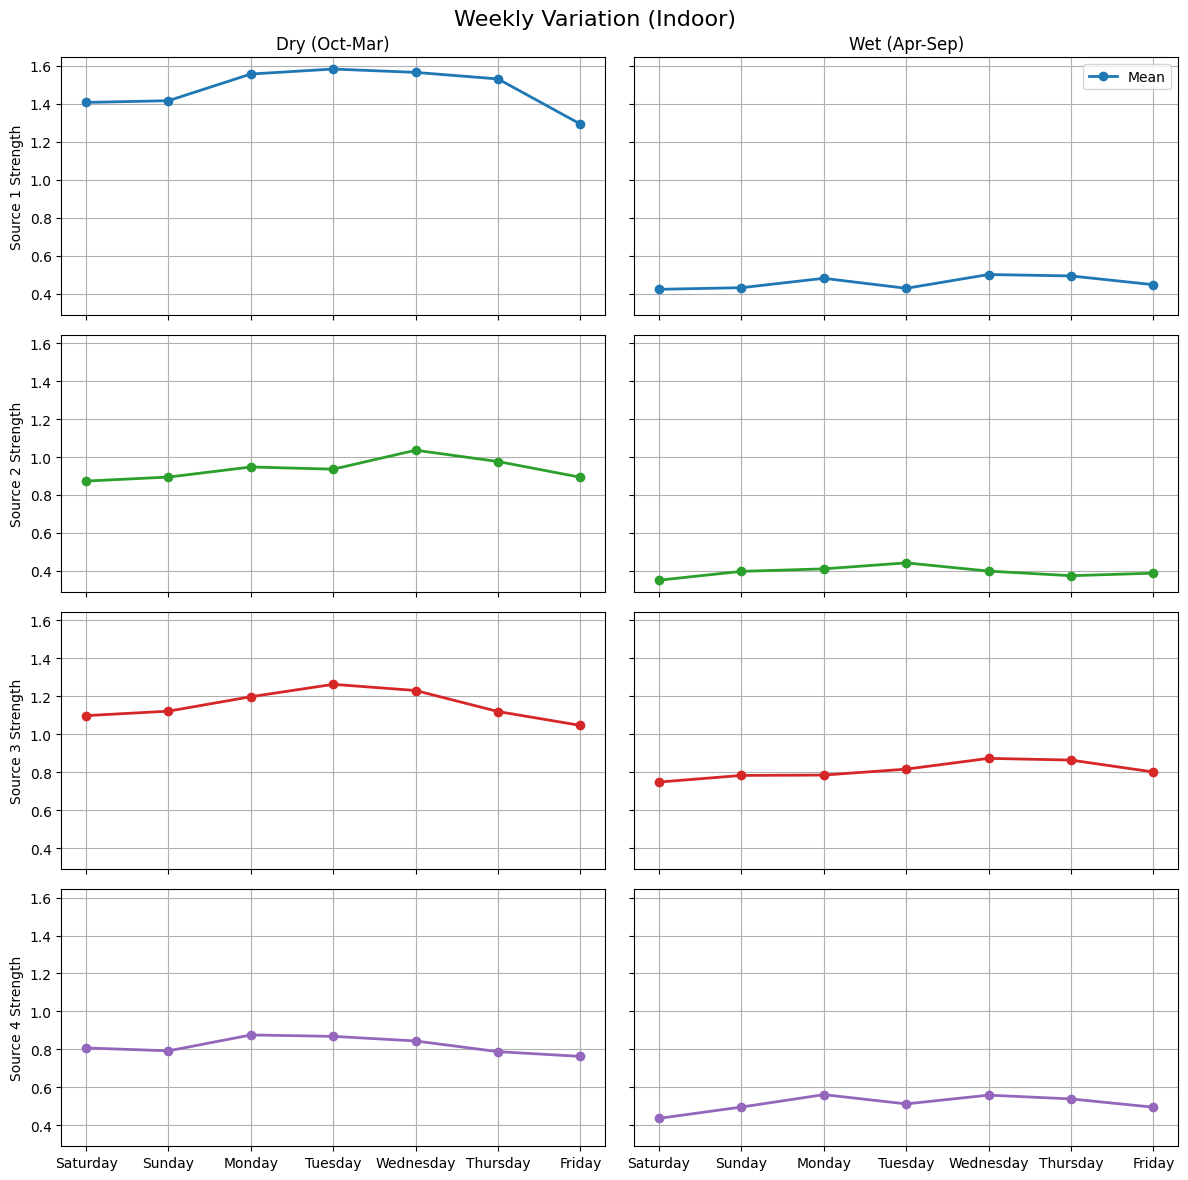

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# List of source columns
source_cols = [col for col in W_in_df.columns if col.startswith('source')]
n_sources = len(source_cols)
season_names = ['Dry (Oct-Mar)', 'Wet (Apr-Sep)']
dry_months = [10, 11, 12, 1, 2, 3]  # October to March
wet_months = [4, 5, 6, 7, 8, 9]

colors = [
    "#1F77B4",  # Steel Blue
    "#2CA02C",  # Emerald Green
    "#D62728",  # Deep Red
    "#9467BD",  # Muted Purple
    "#8C564B",  # Earthy Brown
    "#E377C2",  # Rose Pink
    "#7F7F7F",  # Neutral Gray
    "#17BECF",  # Teal
    "#BCBD22"   # Olive Green
]


season_months = [dry_months, wet_months]
# colors = plt.cm.tab10.colors

fig, axes = plt.subplots(n_sources, 2, figsize=(12, 3 * n_sources), sharex=True, sharey=True)

for row, source in enumerate(source_cols):
    for col, (months, season) in enumerate(zip(season_months, season_names)):
        ax = axes[row, col] if n_sources > 1 else axes[col]
        mask = W_in_df['month'].isin(months)
        df_season = W_in_df[mask]
        # df_season['hour'] = df_season['hour'].apply(lambda x: 24 if x == 0 else x)
        grouped = df_season.groupby('day_of_week')[source]
        mean = grouped.mean()
        q1 = grouped.quantile(0.25)
        q3 = grouped.quantile(0.75)
        days = mean.index
        ax.plot(days, mean, color=colors[row], linewidth=2, marker='o')
        # ax.fill_between(days, q1, q3, color=colors[row], alpha=0.2)
        if row == 0:
            ax.set_title(season)
        if col == 0:
            ax.set_ylabel(f'Source {row+1} Strength')
        ax.set_xticks(mean.index.tolist())
        ax.grid(True)
        if row == 0 and col == 1:
            ax.legend(['Mean', 'IQR (25-75%)'], loc='upper right')

plt.suptitle("Weekly Variation (Indoor)", fontsize=16)
plt.tight_layout()
plt.show()


In [46]:
import numpy as np
import matplotlib.pyplot as plt

# List of source columns
source_cols = [col for col in W_7_df.columns if col.startswith('source')]
n_sources = len(source_cols)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = plt.cm.tab20.colors

fig, axes = plt.subplots(n_sources, 12, figsize=(28, 3 * n_sources), sharex=True, sharey='row')

for row, source in enumerate(source_cols):
    for col, month in enumerate(range(1, 13)):
        ax = axes[row, col] if n_sources > 1 else axes[col]
        mask = W_7_df['month'] == month
        df_month = W_7_df[mask]
        df_month['hour'] = df_month['hour'].apply(lambda x: 24 if x == 0 else x)
        grouped = df_month.groupby('hour')[source]
        mean = grouped.mean()
        q1 = grouped.quantile(0.25)
        q3 = grouped.quantile(0.75)
        hours = mean.index
        ax.plot(hours, mean, color=colors[row % len(colors)])
        ax.fill_between(hours, q1, q3, color=colors[row % len(colors)], alpha=0.2)
        if row == 0:
            ax.set_title(month_names[col])
        if col == 0:
            ax.set_ylabel(f'Source {row+1}\nStrength')
        ax.set_xticks(range(0, 25, 4))
        ax.grid(True)
        if row == 0 and col == 0:
            ax.legend(['Mean', 'IQR (25-75%)'], loc='upper left')

plt.tight_layin()
plt.show()

NameError: name 'W_7_df' is not defined